# **Weather Dataset Preprocessing**

In [1]:
%load_ext autoreload
%autoreload 2


from datetime import datetime
import seaborn as sns

from utils import *

datasets_folder = './datasets'

## **Data Reading**

We start by reading the dataset `csv` and performing some initial column renaming and preprocessing.

In [2]:
weather_folder = os.path.join(datasets_folder,'weather')

weather_df = merge_csv_to_dataframe(weather_folder).rename(columns={'PragaTime':'Date'})
weather_df['Date'] = pd.to_datetime(weather_df['Date'])
weather_df = weather_df.set_index('Date')
weather_df

Merged 6 CSV files


,TAVG,PREC,RHAVG,RAD,W_SCAL_INT,W_VEC_DIR,W_VEC_INT,LEAFW,ET0
Date,,,,,,,,,
2019-01-01 00:00:00,1.0,0.0,92.3,0.0,0.5,208.7,0.3,0.0,0.0
2019-01-01 01:00:00,0.3,0.0,93.6,0.0,0.5,280.0,0.2,0.0,0.0
2019-01-01 02:00:00,0.7,0.0,91.7,0.0,1.1,158.1,1.0,0.0,0.0
2019-01-01 03:00:00,0.4,0.0,91.5,0.0,0.7,189.4,0.4,0.0,0.0
2019-01-01 04:00:00,1.0,0.0,86.3,0.0,0.7,172.9,0.6,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2024-12-30 20:00:00,6.2,0.0,72.1,0.0,2.0,268.9,1.6,0.0,0.0
2024-12-30 21:00:00,5.6,0.0,76.1,0.0,2.5,258.0,2.4,0.0,0.0
2024-12-30 22:00:00,5.7,0.0,75.3,0.0,2.8,254.1,2.7,0.0,0.0


The dataset contains the following informations:
- TAVG → Average Temperature
- PREC → Precipitation
- RHAVG → Average Relative Humidity
- RAD → Solar Radiation
- W_SCAL_INT → Scalar Wind Intensity
- W_VEC_DIR → Vector Wind Direction
- W_VEC_INT → Vector Wind Intensity
- LEAFW → Leaf Wetness
- ET0 → Evapotranspiration

We display a correlation matrix to inspect features that might be connected.

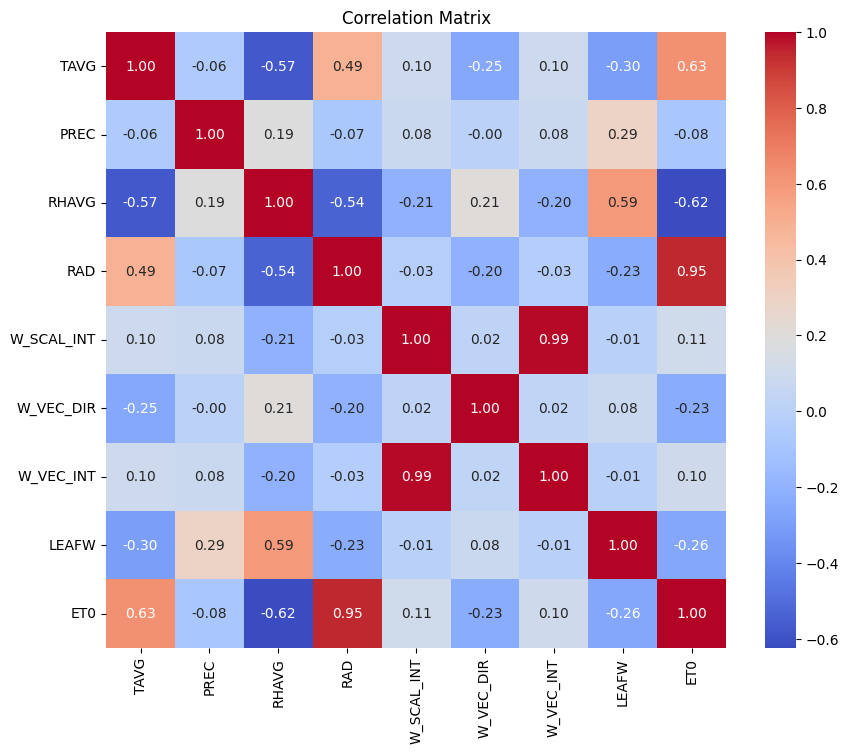

In [3]:
correlation_matrix = weather_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

W_VEC_INT is useless since that we have intensity and direction.

We also drop ET0 because it is highly correlated with RAD, and more than it w.r.t. the other features.

In [4]:
weather_df = weather_df.drop(columns=['W_VEC_INT','ET0'])


There are no missing values nor missing hours inbetween:

In [5]:
weather_df.resample('1h')
weather_df.isna().sum()

TAVG          0
PREC          0
RHAVG         0
RAD           0
W_SCAL_INT    0
W_VEC_DIR     0
LEAFW         0
dtype: int64

## **Daily Aggregation**

When trying to consider a daily representation, the weather, and traffic dataframe, should be aggregated with the right approach to correctly represent the 24 values of the day. For part of the features, a simple sum or average is not meaningful.

The features of the weather dataset can be aggregated as follows:
- Average Temperature (TAVG):
    - a Since it is an average already, we can average the values one more time
    - or we can split the feature into maximum and minimum value of the day
- Precipitation (PREC):
    - total sum of precipitations
- Average Relative Humidity (RHAVG):
    - like for average temperature, we can average the values
    - or split into max and min
- Solar Radiation (RAD):
    - sum of the total solar radiation
- Scalar Wind Intensity (W_SCAL_INT):
    - average intensity value
- Vector Wind Direction (W_VEC_DIR):
    - average vector direction
- Leaf Wetness (LEAFW):
    - count the number of hours where the leafs are wet

Let's apply the reasoning to one day of data:

In [6]:
start = datetime(2019,1,1)
end = datetime(2019,1,2)

one_day_df = weather_df[(weather_df.index>=start)&(weather_df.index<end)]
one_day_df

,TAVG,PREC,RHAVG,RAD,W_SCAL_INT,W_VEC_DIR,LEAFW
Date,,,,,,,
2019-01-01 00:00:00,1.0,0.0,92.3,0.0,0.5,208.7,0.0
2019-01-01 01:00:00,0.3,0.0,93.6,0.0,0.5,280.0,0.0
2019-01-01 02:00:00,0.7,0.0,91.7,0.0,1.1,158.1,0.0
2019-01-01 03:00:00,0.4,0.0,91.5,0.0,0.7,189.4,0.0
2019-01-01 04:00:00,1.0,0.0,86.3,0.0,0.7,172.9,0.0
2019-01-01 05:00:00,2.3,0.0,79.7,0.0,1.8,151.0,0.0
2019-01-01 06:00:00,-0.2,0.0,85.3,0.0,1.8,338.7,0.0
2019-01-01 07:00:00,-0.1,0.0,86.6,0.0,2.1,297.5,0.0
2019-01-01 08:00:00,0.4,0.0,83.8,49.7,3.9,272.4,0.0


The transformation can be applied with the utility function as follows:

In [7]:
aggregations = { # for omitted columns default aggregation is the mean
    'W_SCAL_INT': 'mean',
    'PREC': 'sum',
    'RAD': 'sum',
    'W_VEC_DIR': mean_vector_direction,
    'LEAFW': lambda x: (x > 0).sum()
}

max_min_columns = ['TAVG', 'RHAVG']

transform_weather_to_daily_df(
    one_day_df,
    aggregations=aggregations,
    max_min_columns = max_min_columns,
    keep_splitted_columns=True # if a column is split, also keep it along with average aggregation
)

,TAVG,PREC,RHAVG,RAD,W_SCAL_INT,W_VEC_DIR,LEAFW,TAVG_MAX,TAVG_MIN,RHAVG_MAX,RHAVG_MIN
Date,,,,,,,,,,,
2019-01-01,2.004167,0.0,90.391667,1560.5,2.458333,274.482833,9,3.7,-0.2,99.1,79.7
